<a href="https://colab.research.google.com/github/AarifCha/Statistical-Network/blob/main/CDFInv_Univariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import tensorflow as tf
from typing import Type
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# MLP Builder

In [ ]:
# Helper function for creating a NN
def build_mlp(num_hidden_layers: int,
                hidden_size: int,
                output_size: int,
                activation, #: str = "relu",
                activate_final: bool = False,
                name: str = "mlp"):
    output_sizes = [hidden_size] * num_hidden_layers + [output_size]
    mlp = tf.keras.Sequential(name = name)
    rate = 0.2
    for layer_i, size in enumerate(output_sizes):
        layer_activation = activation
        if not activate_final and layer_i == len(output_sizes) - 1:
            layer_activation = None
    #        rate = 0.0
        mlp.add(tf.keras.layers.Dense(
                size,
                activation = layer_activation,
                use_bias = True,
                kernel_initializer = "HeNormal",#"variance_scaling",#
                bias_initializer = "zeros",
    #              kernel_regularizer = tf.keras.regularizers.L2(0.01),
    #              bias_regularizer = tf.keras.regularizers.L2(0.01),
                name = f"{name}/dense_{layer_i}"))
        #   mlp.add(tf.keras.layers.Dropout(rate))
    return mlp

# Model

In [ ]:
# The CDF Inv Layer
class CDFInv(tf.keras.layers.Layer):
    def __init__(self, *,
                    CDFMLP: Type[tf.keras.layers.Layer],
                    **kwargs):
        super().__init__(name = "CDFInvLayer", **kwargs)
        self._CDFMLP = CDFMLP

    def call(self, uni_rand: tf.Tensor):
        """The call computes both the CDF_inv as well as its gradient
        and returns a tuple with the new random number and 1/pdf at that number.

        Params:
            uni_rand: A random number from 0 to 1 sampled from a uniform distribution.
        Return:
            rand_x: A random number according to the CDF represented by the CDFInv
            one_over_pdf: The gradient of the CDFInv giving 1/pdf(rand_x)
        """
        with tf.GradientTape() as g:
        g.watch(uni_rand)
        rand_x = self._CDFMLP(uni_rand)
        one_over_pdf = self._pdf_avg * tf.reshape(g.gradient(rand_x, uni_rand), (-1,1))
        return rand_x, one_over_pdf

In [ ]:
# Using the CDFInv layer we can create our model
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')

# Use the build_mlp function to create a NN for
# CDFInv
CDFMLP = build_mlp(num_hidden_layers = 5, #5
                        hidden_size = 125, #125
                        output_size = 1,
                        activation = 'tanh', #"tanh"
                        activate_final = False,
                        name = "CDFMLP")

# Initialize the CDFInv layer
CDFInvLayer = CDFInv(CDFMLP = CDFMLP)

# Set up the optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.85),
    )

uni_rand_input = tf.keras.Input(shape = (1,))

output = CDFInvLayer(uni_rand = uni_rand_input)

model = tf.keras.Model(inputs = uni_rand_input, outputs = output, name="CDFInverse")
model.summary()

Model: "CDFInverse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 CDFInvLayer (CDFInv)        ((None, 1),               63376     
                              (None, 1))                         
                                                                 
Total params: 63376 (495.12 KB)
Trainable params: 63376 (495.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Helper function to generate a set of uniform random numbers from 0 to 1
def gen_uni_random(num, batch):
    return tf.reshape(tf.random.uniform((num,),dtype=tf.float64),(-1,batch))

Lets plot what the pdf looks like with a randomly initialized NN.

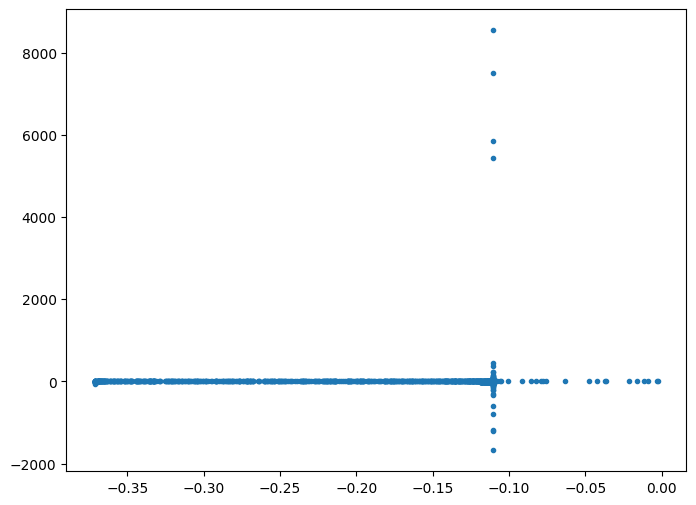

In [ ]:
uni_data = gen_uni_random(1000,1)
x, pdf = model(uni_data)
#pdf = model(uni_data)

#print(x)
plt.figure(figsize=(8, 6))
plt.plot(x, tf.divide(1,pdf), ".")

In [ ]:
a = tf.constant([[0.5], [1]])
#print(a)
rand, pdf = CDFInvLayer(a)
#print(rand)
#print(pdf)

Here we defined the function we wish to integrate.

In [ ]:
@tf.function
def fox(x):
    return (tf.math.cos((x**2))**2)*tf.math.exp(-tf.math.square(x/5)) #(tf.math.cos(4*x)**2)*tf.math.exp(-(x**2/3)) #

Create the dataset for training the model.

In [ ]:
def create_dataset(nb):
    uni_data = gen_uni_random(500*nb,1)
    data = tf.data.Dataset.from_tensor_slices(uni_data).shuffle(buffer_size=1000).batch(nb).shuffle(buffer_size=1000)
    return data
#data.take(1).get_single_element()

nb=500
data = create_dataset(nb)
print(data)

<_ShuffleDataset element_spec=TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)>


## Custom Loss Function

In [ ]:
@tf.function
def custom_loss(y_pred, epoch):
    # print(y_pred)
    x, pdf_inv = y_pred[0], y_pred[1]

    n = tf.cast(tf.shape(x)[0], tf.float64)
    epoch = tf.cast(epoch, tf.float64)


    # computing f/pdf at different points
    # and its mean squared and squar of means.
    fdivP = tf.math.multiply(fox(x), pdf_inv)
    fdivPsq = tf.math.square(fdivP)
    fdivPmean = tf.math.reduce_mean(fdivP)
    fdivPsqmean = tf.math.reduce_mean(fdivPsq)

    # The loss for minimizing the variance to increase Monte Carlo integration convergence.
    var_loss = (fdivPsqmean - tf.math.square(fdivPmean))

    # Loss to prevent the pdf from being negative
    neg_loss = tf.linalg.matmul(tf.linalg.matrix_transpose(tf.cast(tf.less(pdf_inv,0),tf.float64)), tf.math.abs(pdf_inv))

    x0, pdf0 = model(tf.reshape(0.0,(1,)), training=True)
    x1, pdf1 = model(tf.reshape(1.0,(1,)), training=True)

    range = 7

    # Loss to help spread the range of the random numbers produced
    pin_loss = 0.5 * (tf.square(-range - x0) + tf.square(range - x1))

    total_loss =  var_loss + neg_loss + pin_loss
    return total_loss

In [ ]:
test = data.take(1).get_single_element()
test = tf.reshape(test, (-1,1))
#print(test)
custom_loss(CDFInvLayer(test), 1)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[244.31748879]])>

## Custom Training Loop

In [ ]:
@tf.function
def train_step(model, x_batch_train, epoch):
  with tf.GradientTape() as tape:
    pred = model(x_batch_train, training=True)
    #pdf_avg += tf.reduce_sum(pred[1])
    loss_value = custom_loss(pred, epoch)
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  total_loss = tf.reduce_mean(loss_value)
  return total_loss


Epoch 1


Loss: 3.1237: 100%|██████████| 500/500 [00:27<00:00, 18.36it/s]



Epoch 2


Loss: 3.0959: 100%|██████████| 500/500 [00:27<00:00, 18.41it/s]



Epoch 3


Loss: 3.0117: 100%|██████████| 500/500 [00:27<00:00, 18.37it/s]



Epoch 4


Loss: 2.9914: 100%|██████████| 500/500 [00:27<00:00, 18.20it/s]



Epoch 5


Loss: 2.9365: 100%|██████████| 500/500 [00:40<00:00, 12.21it/s]



Epoch 6


Loss: 2.9287: 100%|██████████| 500/500 [00:27<00:00, 18.17it/s]



Epoch 7


Loss: 2.8830: 100%|██████████| 500/500 [00:27<00:00, 18.19it/s]



Epoch 8


Loss: 2.9639: 100%|██████████| 500/500 [00:27<00:00, 18.37it/s]



Epoch 9


Loss: 2.9160: 100%|██████████| 500/500 [00:40<00:00, 12.21it/s]



Epoch 10


Loss: 2.8930: 100%|██████████| 500/500 [00:40<00:00, 12.21it/s]


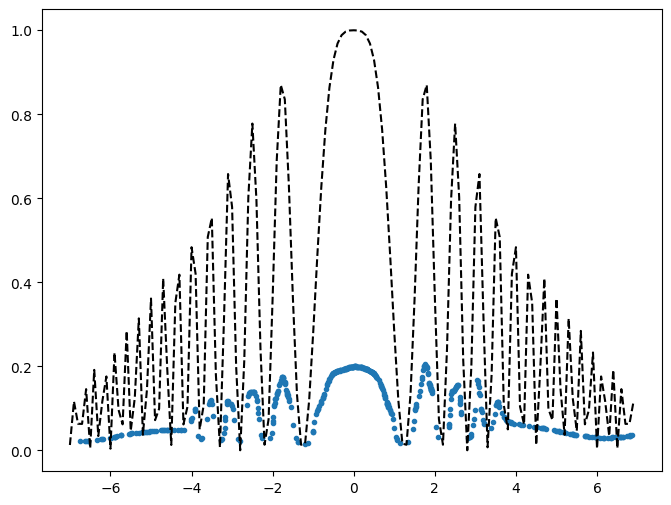

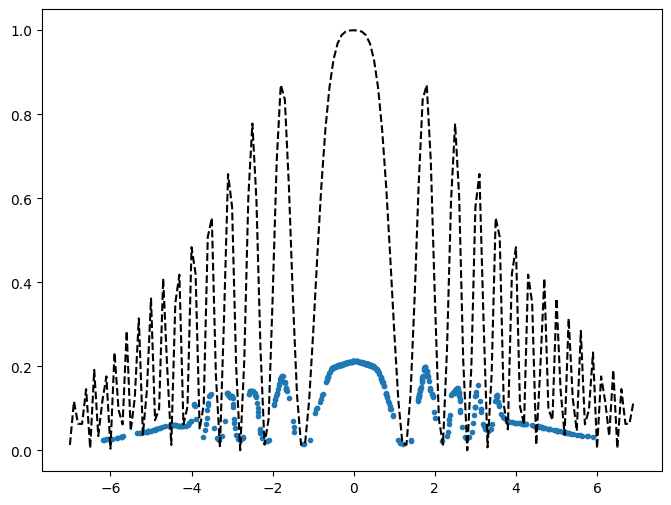

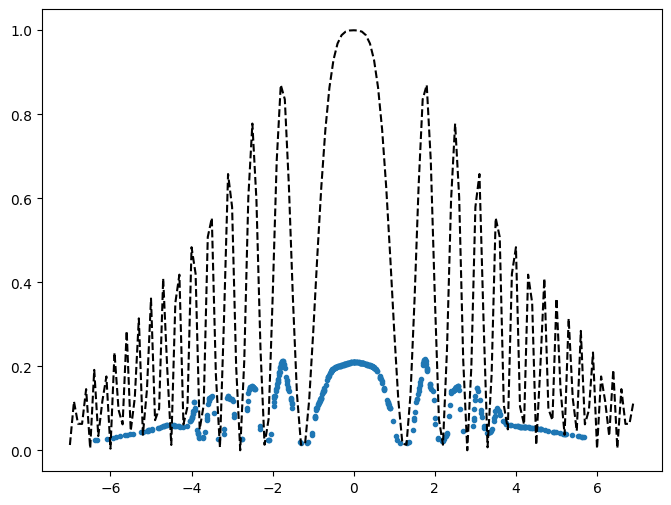

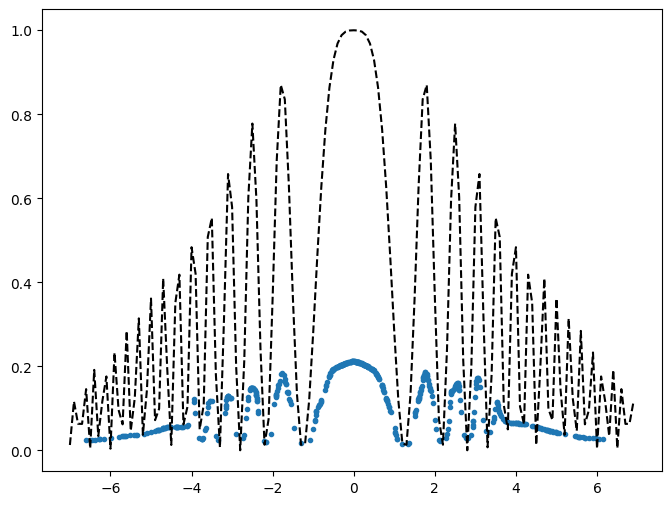

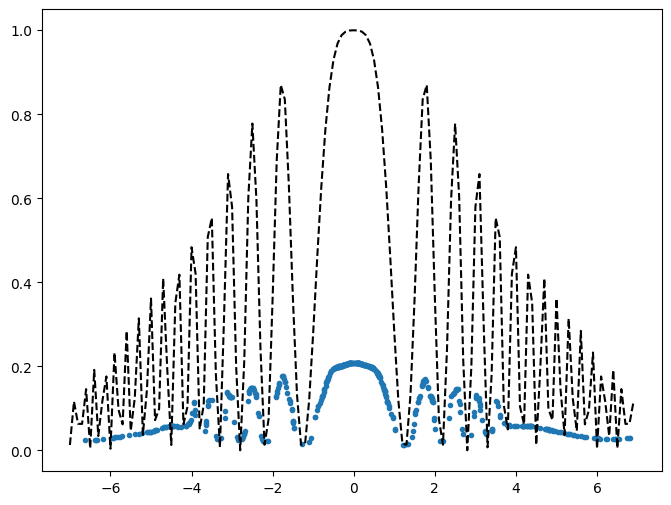

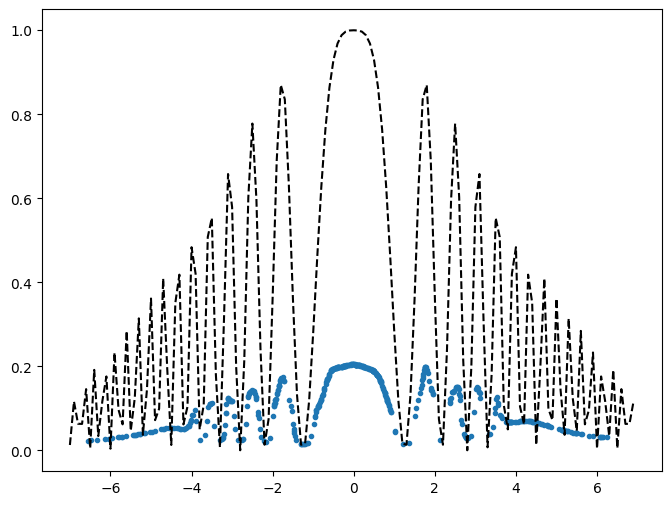

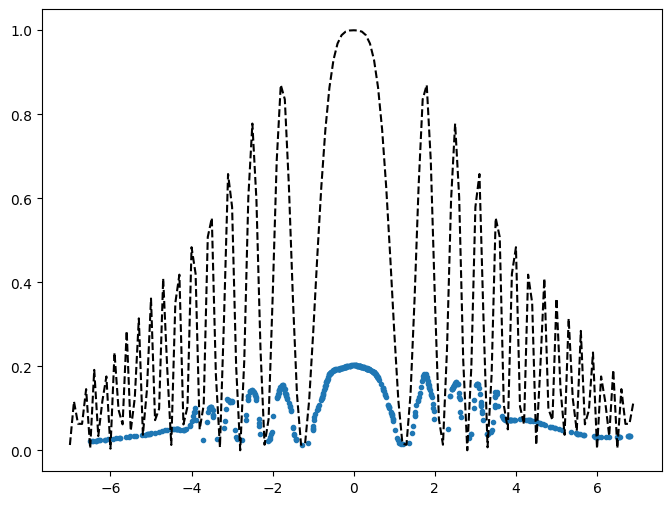

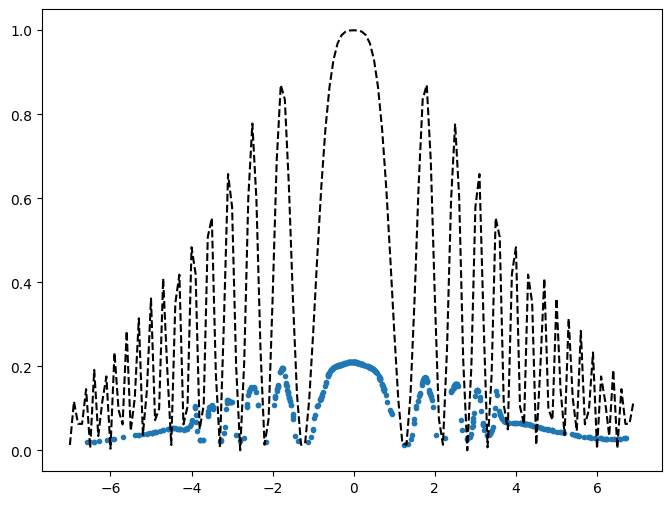

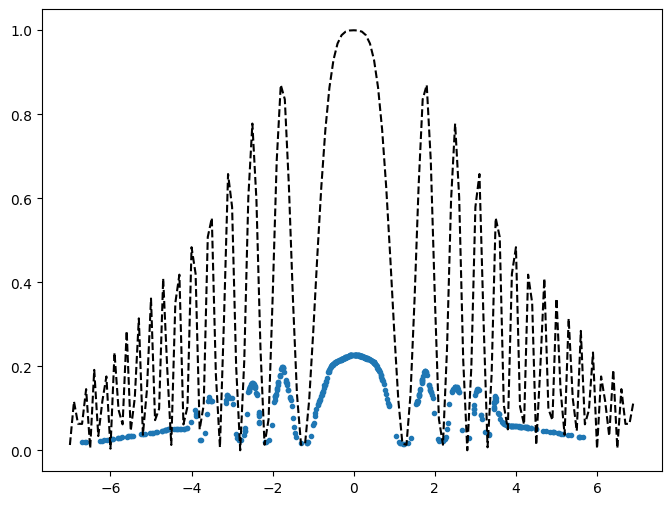

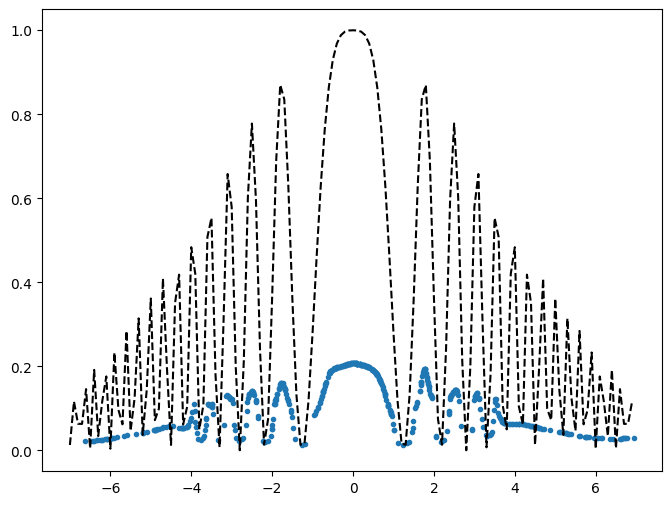

In [ ]:
epochs = 10
steps_per_epoch = data.cardinality().numpy()
for epoch in range(epochs):

    print("\nEpoch %d" % (epoch+1,))
    #data = create_dataset(nb)
    total_loss = 0
    pdf_avg = 0
    with tqdm(total=steps_per_epoch) as pbar:
      for step, x_batch_train in enumerate(data):
        total_loss += train_step(model, x_batch_train, epoch)
        pbar.update(1)
        pbar.set_description(f'Loss: {total_loss / (step + 1):.4f}')

    # Plot the PDF every or every k-th epoch
    if tf.math.floormod(epoch,1) == 0:
      uni_data = gen_uni_random(1*nb,1)
      x, pdf = model(uni_data)

      plt.figure(figsize=(8, 6))
      plt.plot(x, tf.divide(1,pdf), ".")
      va = np.arange(-7, 7, 0.1)
      plt.plot((va), fox(va), "--k")

Now we print the learned PDF as well as generate a set of random points and check if they are indeed distributed according to the learned PDF

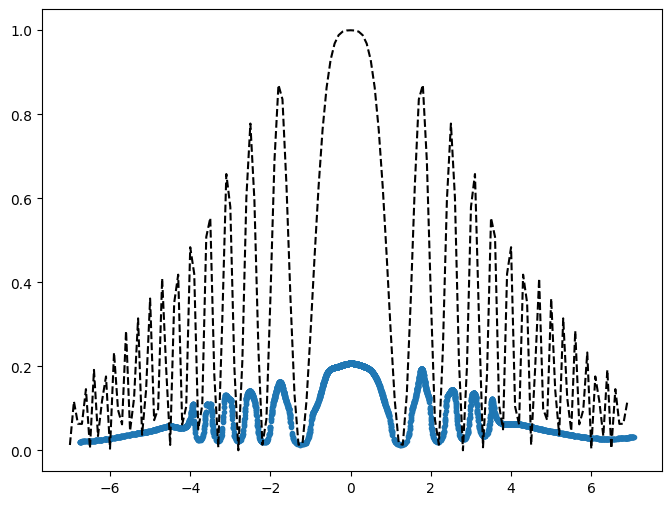

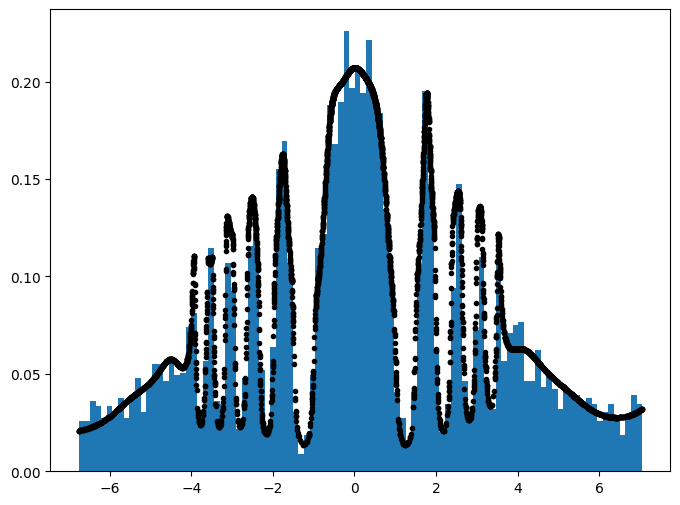

In [ ]:
uni_data = gen_uni_random(10*nb,1)
x, pdf = model(uni_data)
#pdf = model(uni_data)

plt.figure(figsize=(8, 6))
plt.plot(x, tf.divide(1,pdf), ".") #tf.reduce_min(pdf)
va = np.arange(-7, 7, 0.1)
plt.plot((va), fox(va), "--k")
plt.figure(figsize=(8, 6))
a = plt.hist(tf.reshape(x,(-1,)),bins=100, density=True)
plt.plot(x, tf.divide(1,pdf), ".k")